In [1]:
import numpy as np
from scipy.linalg import expm

# fix seed
seed=0 
np.random.seed(seed)

# fix output array
np.set_printoptions(suppress=True,precision=2)

# Deep Policy Gradient (PG)


In this notebook, our goal is to implement the REINFORCE algorithm for policy gradient using [JAX](https://jax.readthedocs.io/en/latest/). We will apply this RL algorithm to control a single quantum bit of information (qubit).  

## The REINFOCE Algorithm

The reinforcement learning objective $J$ is the expected total return, following the policy $\pi$. If the transition probability is denoted by $p(s'|s,a)$, and the initial state distribution is $p(s_0)$, the probability for a trajectory $\tau = (s_0,a_0,r_1,s_1,a_1,\dots,s_{T-1},a_{T-1},r_T,s_T)$ to occur can be written as

$$ 
P_\pi(\tau) = p(s_0)\prod_{t=1}^T \pi(a_t|s_t)p(s_{t+1}|s_t,a_t). 
$$

The RL objective then takes the form

$$
J = \mathrm{E}_{\tau\sim P_\pi} \left[ G(\tau) | S_{t=0}=s_0 \right],\quad G(\tau)=\sum_{t=1}^T r(s_t,a_t).
$$

Policy gradient methods in RL approximate directly the policy $\pi\approx\pi_\theta$ using a variational ansatz, parametrized by the unknown parameters $\theta$. The goal is then to find those optimal parameters $\theta$, which optimize the RL objective $J(\theta)$. To define an update rule for $\theta$, we may use gradient ascent. This requires us to evaluate the gradient of the RL objective w.r.t. the parameters $\theta$:

$$
\nabla_\theta J(\theta) = \nabla_\theta \mathrm{E}_{\tau\sim P_\pi} \left[ \sum_{t=1}^T r(s_t,a_t) | S_{t=0}=s_0 \right] 
= \int\mathrm{d}\tau \nabla_\theta P_{\pi_\theta}(\tau) G(\tau).
$$
In a model-free setting, we don't have access to the transition probabilities $p(s'|s,a)$ and this requires us to be able to estimate the gradients from samples. This can be accomplished by noticing that $\nabla_\theta P_{\pi_\theta} = P_{\pi_\theta} \nabla_\theta \log P_{\pi_\theta}$ (almost everywhere, i.e. up to a set of measure zero):

$$
\nabla_\theta J(\theta) = \int\mathrm{d}\tau \nabla_\theta P_{\pi_\theta}(\tau) G(\tau) = \int\mathrm{d}\tau P_{\pi_\theta}(\tau) \nabla_\theta \log P_{\pi_\theta}(\tau) G(\tau) = \mathrm{E}_{\tau\sim P_\pi} \left[\nabla_\theta \log P_{\pi_\theta}(\tau) G(\tau)\right].
$$
Since the initial state distribution and the transition proabilities are independent of $\theta$, using the definition of $P_{\pi_\theta}$, we see that $\nabla_\theta P_{\pi_\theta}(\tau) = \nabla_\theta \pi_\theta(\tau)$ where $\pi_\theta(\tau) = \prod_{t=1}^T \pi(a_t|s_t)$. 

We can now use MC to estimate the gradients directly from a sample of trajectories $\{\tau_j\}_{j=1}^N$:
$$
\nabla_\theta J(\theta) = \mathrm{E}_{\tau\sim P_\pi} \left[\nabla_\theta \log \pi_\theta(\tau) G(\tau)\right]
\approx \frac{1}{N}\sum_{j=1}^N \nabla_\theta \log \pi_\theta(\tau_j) G(\tau_j).
$$

To alleviate the problem with the large variance of the gradient estimate, one can introduce a baseline $b$. The PG update then rakes the form

$$
\nabla_\theta J(\theta)
\approx \frac{1}{N}\sum_{j=1}^N \sum_{t=1}^T \nabla_\theta \log \pi_\theta(a^j_t|s^j_t) \left[\sum_{t'=t}^T r(a^j_{t'}|s^j_{t'})) - b\right].
$$

One can show that adding this baseline term does not change the gradient of the objective.

The corresponding gradient ascent update rule reads as

$$
\theta \leftarrow \theta + \alpha \nabla_\theta J(\theta),
$$
for some step size (or learning rate) $\alpha$. 



## Qubit Environment

Let us define the qubit environment that models the action of gates on the state of the two-level system (2LS).

### Basic Definitions

The state of a qubit $|\psi\rangle\in\mathbb{C}^2$ is modeled by a two-dimensional complex-valued vector with unit norm: $\langle\psi|\psi\rangle:=\sqrt{|\psi_1|^2+|\psi_2|^2}=1$. Every qubit state is uniquely described by two angles $\theta\in[0,\pi]$ and $\varphi\in[0,2\pi)$:

\begin{eqnarray}
|\psi\rangle=
\begin{pmatrix}
\psi_1 \\ \psi_2
\end{pmatrix}=
\mathrm{e}^{i\alpha}
\begin{pmatrix}
\cos\frac{\theta}{2} \\
\mathrm{e}^{i\varphi}\sin\frac{\theta}{2}
\end{pmatrix}
\end{eqnarray}

The overall phase $\alpha$ of a single quantum state has no physical meaning.
Thus, any qubit state can be pictured as an arrow on the unit sphere (called the Bloch sphere) with angular coordinates $(\theta,\varphi)$. 

To operate on qubits, we use quantum gates. Quantum gates are represented as unitary transformations $U\in \mathrm{U(2)}$, where $\mathrm{U(2)}$ is the unitary group. Gates act on qubit states by matrix multiplication to transform an input state $|\psi\rangle$ to the output state $|\psi'\rangle$: $|\psi'\rangle=U|\psi\rangle$. For this problem, we consider four gates

\begin{equation}
U_0=\boldsymbol{1},\qquad 
U_x=\mathrm{exp}(-i\delta t \sigma^x/2),\qquad
U_y=\mathrm{exp}(-i\delta t \sigma^y/2),\qquad 
U_z=\mathrm{exp}(-i\delta t \sigma^z/2),
\end{equation}

where $\delta t$ is a fixed time step, $\mathrm{exp}(\cdot)$ is the matrix exponential, $\boldsymbol{1}$ is the identity, and the Pauli matrices are defined as

\begin{equation}
\boldsymbol{1}=\begin{pmatrix}
1 & 0 \\ 0 & 1
\end{pmatrix}
,\qquad
\sigma^x=\begin{pmatrix}
0 & 1 \\ 1 & 0
\end{pmatrix}
,\qquad
\sigma^y=\begin{pmatrix}
0 & -i \\ i & 0
\end{pmatrix}
,\ \qquad
\sigma^z=\begin{pmatrix}
1 & 0 \\ 0 & -1
\end{pmatrix}
\end{equation}

To determine if a qubit, described by the state $|\psi\rangle$, is in a desired target state $|\psi_\mathrm{target}\rangle$, we compute the fidelity

\begin{eqnarray}
F=|\langle\psi_\mathrm{target}|\psi\rangle|^2 = |(\psi_\mathrm{target})^\ast_1 \psi_1 + (\psi_\mathrm{target})^\ast_2 \psi_2|^2,\qquad F\in[0,1]
\end{eqnarray}

where $\ast$ stands for complex conjugation. Physically, the fidelity corresponds to the angle between the arrows representing the qubit state on the Bloch sphere (we want to maximize the fidelity but minimize the angle between the states).

### Constructing the Qubit Environment

Now, let us define an episodic RL environment, which contains the laws of physics that govern the dynamics of the qubit (i.e. the application of the gate operations to the qubit state). Our RL agent will later interact with this environment to learn how to control the qubit to bring it from an initial state to a prescribed target state. 

We define the RL states $s=(\theta,\varphi)$ as an array containing the Bloch sphere angles of the quantum state. Each step within an episode, the agent can choose to apply one out of the actions, corresponding to the four gates $(\boldsymbol{1},U_x,U_y,U_z)$. We use the instantaneous fidelity w.r.t. the target state as a reward: $r_t=F=|\langle\psi_\ast|\psi(t)\rangle|^2$: 

**state space:** $\mathcal{S} = \{(\theta,\varphi)|\theta\in[0,\pi],\varphi\in[0,2\pi)\}$. There are no well-defined terminal state in this task. Instead, we consider a fixed number of time steps, after which the episode terminates deterministically. The target state (i.e. the qubit state we want to prepare) is $|\psi_\mathrm{target}\rangle=(1,0)^t$: it has the Bloch sphere coordinates $s_\mathrm{target}=(0,0)$.

**action space:** $\mathcal{A} = \{\boldsymbol{1},U_x,U_y,U_z\}$. Actions act on RL states as follows: 
1. if the current state is $s=(\theta,\varphi)$, we first create the quantums state $|\psi(s)\rangle$; 
2. we apply the gate $U_a$ corresponding to action $a$ to the quantum state, and obtain the new quantum state $|\psi(s')\rangle = U_a|\psi(s)\rangle$. 
3. last, we compute the Bloch sphere coordinates which define the next state $s'=(\theta',\varphi')$, using the Bloch sphere parametrization for qubits given above.
Note that all actions are allowed from every state. 


**reward space:** $\mathcal{R}=[0,1]$. We use the fidelity between the next state $s'$ and the terminal state $s_\mathrm{target}$ as a reward at every episode step: 

$$r(s,s',a)= F = |\langle\psi_\mathrm{target}|U_a|\psi(s)\rangle|^2=|\langle\psi_\mathrm{target}|\psi(s')\rangle|^2$$

for all states $s,s'\in\mathcal{S}$ and actions $a\in\mathcal{A}$. 

In [2]:
class QubitEnv():
    """
    Gym style environment for RL. You may also inherit the class structure from OpenAI Gym. 
    Parameters:
        n_time_steps:   int
                        Total number of time steps within each episode
        seed:   int
                seed of the RNG (for reproducibility)
    """
    
    def __init__(self, n_time_steps, seed):
        """
        Initialize the environment.
        
        """
        
        self.n_time_steps = n_time_steps
        
        
        ### define action space variables
        self.n_actions = 4 # action space size
        delta_t = 2*np.pi/n_time_steps # set a value for the time step
        # define Pauli matrices
        Id     =np.array([[1.0,0.0  ], [0.0 ,+1.0]])
        sigma_x=np.array([[0.0,1.0  ], [1.0 , 0.0]])
        sigma_y=np.array([[0.0,-1.0j], [1.0j, 0.0]])
        sigma_z=np.array([[1.0,0.0  ], [0.0 ,-1.0]])
        
        self.action_space=[]
        for generator in [Id, sigma_x, sigma_y, sigma_z]:
            self.action_space.append( expm(-1j*delta_t*generator) )
        
        self.actions = np.array([0,1,2,3])
        
        
        ### define state space variables
        self.S_target = np.array([0.0,0.0])
        self.psi_target = self.RL_to_qubit_state(self.S_target)
        
        
        # set seed
        self.set_seed(seed)
        self.reset()
    
    
    def step(self, action):
        """
        Interface between environment and agent. Performs one step in the environemnt.
        Parameters:
            action: int
                    the index of the respective action in the action array
        Returns:
            output: ( object, float, bool)
                    information provided by the environment about its current state:
                    (state, reward, done)
        """

        # apply gate to quantum state
        self.psi = self.action_space[action].dot(self.psi)
        
        # compute RL state
        self.state = self.qubit_to_RL_state(self.psi)
        
        # compute reward
        reward = np.abs( self.psi_target.conj().dot(self.psi)  )**2
        
        
        # check if state is terminal
        done=False
        

        return self.state, reward, done

    
    
    def set_seed(self,seed=0):
        """
        Sets the seed of the RNG.
        
        """
        np.random.seed(seed)
    
    
    
    def reset(self, random=True):
        """
        Resets the environment to its initial values.
        Returns:
            state:  object
                    the initial state of the environment
            random: bool
                    controls whether the initial state is a random state on the sphere or a fixed initial state.
        """
        
        if random:
            theta = np.pi*np.random.uniform(0.0,1.0)
            phi = 2*np.pi*np.random.uniform(0.0,1.0)
        else:
            # start from south pole of Bloch sphere
            theta=np.pi
            phi=0.0
        
        self.state=np.array([theta,phi])
        self.psi=self.RL_to_qubit_state(self.state)

        return self.state

    
    
    def render(self):
        """
        Plots the state of the environment. For visulization purposes only. Feel free to ignore. 

        """
        pass
    
    
    def RL_to_qubit_state(self,s):
        """
        Take as input the RL state s, and return the quantum state |psi>
        """
        theta, phi = s
        psi = np.array([np.cos(0.5*theta), np.exp(1j*phi)*np.sin(0.5*theta)] )
        return psi
    
    
    def qubit_to_RL_state(self,psi):
        """
        Take as input the RL state s, and return the quantum state |psi>
        """
        # take away unphysical global phase
        alpha = np.angle(psi[0])
        psi_new = np.exp(-1j*alpha) * psi 
        
        # find Bloch sphere angles
        theta = 2.0*np.arccos(psi_new[0]).real
        phi = np.angle(psi_new[1])
        
        return np.array([theta, phi])

Let us test how the qubit environment works.

In [3]:
# set seed of rng (for reproducibility of the results)
n_time_steps = 60 # steps of each episode

# create environment and reset it to a random initial state
env=QubitEnv(n_time_steps,seed)
env.reset(random=True)

done=False
j=0
while j < n_time_steps:
    
    # pick a random action
    action=np.random.choice([0,1,2,3]) # equiprobable policy
    
    # take an environment step
    state=env.state.copy()
    state_p, reward, done = env.step(action)
    
    print("{}. s={}, a={}, r={}, s'={}\n".format(j, state, action, np.round(reward,6), state_p))
    
    j+=1
    
    if done:
        print('\nreached terminal state!')
        break

0. s=[1.89 3.42], a=1, r=0.317401, s'=[ 1.94 -2.93]

1. s=[ 1.94 -2.93], a=3, r=0.317401, s'=[ 1.94 -2.72]

2. s=[ 1.94 -2.72], a=1, r=0.282162, s'=[ 2.02 -2.81]

3. s=[ 2.02 -2.81], a=2, r=0.37539, s'=[ 1.82 -2.83]

4. s=[ 1.82 -2.83], a=0, r=0.37539, s'=[ 1.82 -2.83]

5. s=[ 1.82 -2.83], a=3, r=0.37539, s'=[ 1.82 -2.62]

6. s=[ 1.82 -2.62], a=2, r=0.465631, s'=[ 1.64 -2.64]

7. s=[ 1.64 -2.64], a=0, r=0.465631, s'=[ 1.64 -2.64]

8. s=[ 1.64 -2.64], a=0, r=0.465631, s'=[ 1.64 -2.64]

9. s=[ 1.64 -2.64], a=0, r=0.465631, s'=[ 1.64 -2.64]

10. s=[ 1.64 -2.64], a=2, r=0.557374, s'=[ 1.46 -2.64]

11. s=[ 1.46 -2.64], a=1, r=0.506358, s'=[ 1.56 -2.63]

12. s=[ 1.56 -2.63], a=2, r=0.596708, s'=[ 1.38 -2.62]

13. s=[ 1.38 -2.62], a=3, r=0.596708, s'=[ 1.38 -2.41]

14. s=[ 1.38 -2.41], a=3, r=0.596708, s'=[ 1.38 -2.2 ]

15. s=[ 1.38 -2.2 ], a=2, r=0.654397, s'=[ 1.26 -2.15]

16. s=[ 1.26 -2.15], a=0, r=0.654397, s'=[ 1.26 -2.15]

17. s=[ 1.26 -2.15], a=1, r=0.568402, s'=[ 1.43 -2.13]

18. s=[

## Policy Gradient Implementation

The implementation of the PG algorithm proceeds as follows:

1. Define the a SoftMax model for the discrete policy $\pi_\theta$.
2. Define the pseudo loss function to easily compute $\nabla_\theta J(\theta)$.
3. Define generalized gradient descent optimizer.
4. Define the PG training loop and train the policy.

*Note:* if you are familiar with solving the MNIST problem, you will recognize many of the steps used to construct and train the neural network. What is different here is the training algorithm.

### Define a SoftMax model for the discrete policy $\pi_\theta$

Use JAX to construct a feed-forward fully-connected deep neural network with neuron acrchitecture $(M_s, 512, 256, |\mathcal{A}|)$, where there are $512$ ($256$) neurons in the first (second) hidden layer, respectively, and $M_s$ and $|\mathcal{A}|$ define the input and output sizes.

The input data into the neural network should have the shape `input_shape = (-1, n_time_steps, M_s)`, where `M_s` is the number of features/components in the RL state $s=(\theta,\varphi)$. The output data should have the shape `output_shape = (-1, n_time_steps, abs_A)`, where `abs_A`$=|\mathcal{A}|$. In this way, we can use the neural network to process simultaneously all time steps and MC samples, generated in a single training iteration. 

Check explicitly the output shape and test that the network runs on some fake data (e.g. a small batch of vectors of ones with the appropriate shape). 

In [4]:
import jax.numpy as jnp # jax's numpy version with GPU support
from jax import random # used to define a RNG key to control the random input in JAX
from jax.example_libraries import stax # neural network library
from jax.example_libraries.stax import Dense, Relu, LogSoftmax # neural network layers

# set key for the RNG (see JAX docs)
rng = random.PRNGKey(seed)

# define functions which initialize the parameters and evaluate the model
initialize_params, predict = stax.serial(
                                            ### fully connected DNN
                                            Dense(512), # 512 hidden neurons
                                            Relu,
                                            Dense(256), # 256 hidden neurons
                                            Relu,
                                            Dense(env.n_actions), # 4 output neurons
                                            LogSoftmax # NB: computes the log-probability
                                        )

# initialize the model parameters
input_shape = (-1,env.n_time_steps,2) # -1: number of MC points, number of time steps, size of state vector
output_shape, inital_params = initialize_params(rng, input_shape) # fcc layer 28x28 pixes in each image

print('\noutput shape of the policy network is {}.\n'.format(output_shape))


# test network
states=np.ones((3,env.n_time_steps,2), dtype=np.float32)

predictions = predict(inital_params, states)
# check the output shape
print(predictions.shape)


output shape of the policy network is (-1, 60, 4).

(3, 60, 4)


### Define the pseudo loss function to easily compute $\nabla_\theta J(\theta)$

REINFORCE allows to define a scalar pseudoloss function, whose gradients give $\nabla_\theta J(\theta)$. Note that this pseudoloss does ***NOT*** correspond to the RL objective $J(\theta)$: the difference stems from the fact that the two operations of taking the derivative and performing the MC approximation are not interchangeable (do you see why?).  

$$
J_\mathrm{pseudo}(\theta) = 
\frac{1}{N}\sum_{j=1}^N \sum_{t=1}^T \log \pi_\theta(a^j_t|s^j_t) \left[\sum_{t'=t}^T r(a^j_{t'}|s^j_{t'}) - b_t\right],\qquad 
b_t = \frac{1}{N}\sum_{j=1}^N G_t(\tau_j).
$$
The baseline is a sample average of the reward-to-go (return) from time step $t$ onwards: $G_t(\tau_j) = \sum_{t'=t}^N r(s^j_{t'},s^j_{t'})$ .

Because we will be doing gradient **a**scent, do **NOT** forget to add an extra minus sign to the output ot the pseudoloss (or else your agent will end up minimizing the return). 

Below, we also add an L2 regularizer to the pseudoloss function to prevent overfitting. 

In [5]:
### define loss and accuracy functions

from jax import grad
from jax.tree_util import tree_flatten # jax params are stored as nested tuples; use this to manipulate tuples


def l2_regularizer(params, lmbda):
    """
    Define l2 regularizer: $\lambda \ sum_j ||theta_j||^2 $ for every parameter in the model $\theta_j$
    
    """
    return lmbda*jnp.sum(jnp.array([jnp.sum(jnp.abs(theta)**2) for theta in tree_flatten(params)[0] ]))


def pseudo_loss(params, trajectory_batch):
    """
    Define the pseudo loss function for policy gradient. 
    
    params: object(jax pytree):
        parameters of the deep policy network.
    trajectory_batch: tuple (states, actions, returns) containing the RL states, actions and returns (not the rewards!): 
        states: np.array of size (N_MC, env.n_time_steps,2)
        actions: np.array of size (N_MC, env.n_time_steps)
        returns: np.array of size (N_MC, env.n_time_steps)
    
    Returns:
        -J_{pseudo}(\theta)

    """
    # extract data from the batch
    states, actions, returns = trajectory_batch
    # compute policy predictions
    preds = predict(params, states)
    # combute the baseline
    baseline = jnp.mean(returns, axis=0)
    # select those values of the policy along the action trajectory
    preds_select = jnp.take_along_axis(preds, jnp.expand_dims(actions, axis=2), axis=2).squeeze()
    # return negative pseudo loss function (want to maximize reward with gradient DEscent)
    return -jnp.mean(jnp.sum(preds_select * (returns - baseline) )) + l2_regularizer(params, 0.001)



### Define generalized gradient descent optimizer

Define the optimizer and the `update` function which computes the gradient o the pseudo-loss function and performs the update. 

We use the Adam optimizer here with `step_size = 0.001` and the rest of the parameters have default values. 

In [6]:
### define generalized gradient descent optimizer and a function to update model parameters

from jax.example_libraries import optimizers # gradient descent optimizers
from jax import jit

step_size = 0.001 # step size or learning rate 

# compute optimizer functions
opt_init, opt_update, get_params = optimizers.adam(step_size)


# define function which updates the parameters using the change computed by the optimizer
@jit # Just In Time compilation speeds up the code; requires to use jnp everywhere; remove when debugging
def update(i, opt_state, batch):
    """
    i: int,
        counter to count how many update steps we have performed
    opt_state: object,
        the state of the optimizer
    batch: np.array
        batch containing the data used to update the model
        
    Returns: 
    opt_state: object,
        the new state of the optimizer
        
    """
    # get current parameters of the model
    current_params = get_params(opt_state)
    # compute gradients
    grad_params = grad(pseudo_loss)(current_params, batch)
    # use the optimizer to perform the update using opt_update
    return opt_update(i, grad_params, opt_state)

### Define the PG training loop and train the policy

Finally, we implement the REINFORCE algorithm for policy gradient. Follow the steps below:

1. Preallocate variables
    * Define the number of episodes `N_episodes`, and the batch size `N_MC`.
    * Preallocate arrays for the current `state`, and the `states`, `actions`, `returns` triple which defines the trajectory batch. 
    * Preallocate arrays to compute the `mean_final_reward`, `std_final_reward`, `min_final_reward`, and , `max_final_reward`.
2. Initialize the optimizer using the `opt_init` function. 
3. Loop over the episodes; for every episode:

    3.1 get the current Network parameters
    
    3.2 loop to collect MC samples
        
      3.2.1 reset the `env` and roll out the policy until the episode is over; collect the trajectory data
    
      3.2.2 compute the returns (rewards to go)
    
    3.3 compile the PG data into a trajctory batch
    
    3.4 use the `update` function to update the network parameters
    
    3.5 print instantaneous performance

In [7]:
### Train model

import time

# define number of training episodes
N_episodes = 201 # total number of training episodes
N_MC = 64 #128 # number of trajectories in the batch


# preallocate data using arrays initialized with zeros
state=np.zeros((2,), dtype=np.float32)
    
states = np.zeros((N_MC, env.n_time_steps,2), dtype=np.float32)
actions = np.zeros((N_MC, env.n_time_steps), dtype=np.int64)
returns = np.zeros((N_MC, env.n_time_steps), dtype=np.float32)
    
# mean reward at the end of the episode
mean_final_reward = np.zeros(N_episodes, dtype=np.float32)
# standard deviation of the reward at the end of the episode
std_final_reward = np.zeros_like(mean_final_reward)
# batch minimum at the end of the episode
min_final_reward = np.zeros_like(mean_final_reward)
# batch maximum at the end of the episode
max_final_reward = np.zeros_like(mean_final_reward)


print("\nStarting training...\n")

# set the initial model parameters in the optimizer
opt_state = opt_init(inital_params)

# loop over the number of training episodes
for episode in range(N_episodes): 
    
    ### record time
    start_time = time.time()
    
    # get current policy  network params
    current_params = get_params(opt_state)
    
    # MC sample
    for j in range(N_MC):
        
        # reset environment to a random initial state
        #env.reset(random=False) # fixed initial state
        env.reset(random=True) # Haar-random initial state (i.e. uniformly sampled on the sphere)
    
        # zero rewards array (auxiliary array to store the rewards, and help compute the returns)
        rewards = np.zeros((env.n_time_steps, ), dtype=np.float32)
    
        # loop over steps in an episode
        for time_step in range(env.n_time_steps):

            # select state
            state[:] = env.state[:]
            states[j,time_step,:] = state

            # select an action according to current policy
            pi_s = np.exp( predict(current_params, state) )
            action = np.random.choice(env.actions, p = pi_s)
            actions[j,time_step] = action

            # take an environment step
            state[:], reward, _ = env.step(action)

            # store reward
            rewards[time_step] = reward
            
            
        # compute reward-to-go 
        returns[j,:] = jnp.cumsum(rewards[::-1])[::-1]
        
        
            
    # define batch of data
    trajectory_batch = (states, actions, returns)
    
    # update model
    opt_state = update(episode, opt_state, trajectory_batch)
            
    ### record time needed for a single epoch
    episode_time = time.time() - start_time
    
    # check performance
    mean_final_reward[episode]=jnp.mean(returns[:,-1])
    std_final_reward[episode] =jnp.std(returns[:,-1])
    min_final_reward[episode], max_final_reward[episode] = np.min(returns[:,-1]), np.max(returns[:,-1])

    
    # print results every 10 epochs
    #if episode % 5 == 0:
    print("episode {} in {:0.2f} sec".format(episode, episode_time))
    print("mean reward: {:0.4f}".format(mean_final_reward[episode]) )
    print("return standard deviation: {:0.4f}".format(std_final_reward[episode]) )
    print("min return: {:0.4f}; max return: {:0.4f}\n".format(min_final_reward[episode], max_final_reward[episode]) )


Starting training...

episode 0 in 7.50 sec
mean reward: 0.4893
return standard deviation: 0.2976
min return: 0.0093; max return: 0.9973

episode 1 in 5.27 sec
mean reward: 0.5089
return standard deviation: 0.2988
min return: 0.0197; max return: 0.9954

episode 2 in 4.45 sec
mean reward: 0.5773
return standard deviation: 0.2473
min return: 0.1093; max return: 0.9966

episode 3 in 2.95 sec
mean reward: 0.5914
return standard deviation: 0.2809
min return: 0.0190; max return: 0.9989

episode 4 in 2.35 sec
mean reward: 0.5910
return standard deviation: 0.2662
min return: 0.0206; max return: 0.9969

episode 5 in 2.33 sec
mean reward: 0.5786
return standard deviation: 0.2607
min return: 0.0034; max return: 0.9978

episode 6 in 2.32 sec
mean reward: 0.5554
return standard deviation: 0.2453
min return: 0.0214; max return: 0.9538

episode 7 in 2.32 sec
mean reward: 0.6352
return standard deviation: 0.2590
min return: 0.0764; max return: 0.9860

episode 8 in 2.38 sec
mean reward: 0.6361
return 

## Plot the training curves

Plot the mean final reward at each episode, and its variance. What do you observe?

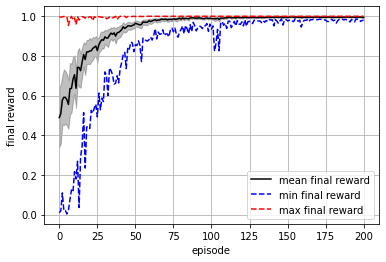

In [8]:
import matplotlib
from matplotlib import pyplot as plt
# static plots
%matplotlib inline 

### plot and examine learning curves

episodes=list(range(N_episodes))

plt.plot(episodes, mean_final_reward, '-k', label='mean final reward' )
plt.fill_between(episodes, 
                 mean_final_reward-0.5*std_final_reward, 
                 mean_final_reward+0.5*std_final_reward, 
                 color='k', 
                 alpha=0.25)

plt.plot(episodes, min_final_reward, '--b' , label='min final reward' )
plt.plot(episodes, max_final_reward, '--r' , label='max final reward' )

plt.xlabel('episode')
plt.ylabel('final reward')

plt.legend(loc='lower right')
plt.grid()
plt.show()

## Questions

0. Try out different batch sizes and hyperparameters (including different network architectures). Can you improve the performance?

1. Explore the final batch of trajectories. Check the sequence of actions. Can you make sense of the solution found by the agent? Hint: think of the dynamics on the Bloch sphere and try to visualize the trajectory there.

2. Compare the Policy Gradient method to conventional optimal control: can optimal control give you a control protocol that works for all states? Why or why not? 

3. Take one of the high-reward tranjectories in the final batch of data. Now perturb it manually at a few time steps in the first half of the protocol such that it no longer produces an optimal reward (you would have to add a function to the environment which evalues a given trajectory). Last, use the policy to see how it would react to those perturbations in real time. Will it correct on-line for the introduced mistakes (i.e. before the opisode is over)? 

4. Find ways to visualize the policy. What is a meaningful way to do that? 

## Advanced Problems

1. What is the initial state distribution $p(s_0)$ in the implementation above? Check the performance of the PG algorith if $p(s_0)$ is 
    * a delta distribution 
    * a compactly-supported uniform distribution over some sector of the sphere (say a cap around the south pole)
    * a Gaussian distribution with non-compact support 
    
2. Introduce small Gaussian noise to the rewards, e.g. $r(s,a) \to r(s,a) + \delta r$ where $\delta r \sim \mathcal{N}(0,\delta)$ for some noise strength $\delta$. Does this lead to a serious performance drop as you vary $\delta\in[0,0.5]$? Why or why not?
    
2. The loop over the $N_{MC}$ trajectories slows down the algorithm significantly. Consider ways to speed up the evaluation of a single PG iteration. This may include a modification of the environment `QubitEnv` or the use of parallelization software (see JAX's function [`vmap`](https://jax.readthedocs.io/en/latest/jax.html#vectorization-vmap) and [`pmap`](https://jax.readthedocs.io/en/latest/jax.html#parallelization-pmap)). 
    
3. Change the environment `QubitEnv` to define a nonepisodic task. Additionally, introduce a "stop" action so that when the agent bring the RL state close to $s_\mathrm{target}$ the episode comes to an end and the environment is reset. This would require you to also modify the Policy Gradient implementation above because episodes now can have different length.  